<a href="https://colab.research.google.com/github/ceciliasecchi/MasterThesis/blob/main/MasterThesis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-process of the data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli 
from scipy.special import softmax as scipy_softmax
import pandas as pd
!pip install wordfreq
from wordfreq import word_frequency
from nltk.collections import OrderedDict
import gensim
import pandas as pd
import nltk
nltk.download('punkt')
import re  # For preprocessing
import string
import numpy as np
from numpy import linalg as LA
import csv
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from gensim.parsing.preprocessing import remove_stopwords,preprocess_string,preprocess_documents
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
import collections
from collections import defaultdict
from typing import DefaultDict



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.8 MB 18 kB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Reads ‘tweets.txt’ file
sample = open("tweets.txt", "r")
s = sample.read()

stopp = {'and','hes','but','this','said','you','the','how','for','like','thats',
         'like','thought','again','but','dont','that','ive','didnt','they','she',
         'while','instead','would','thats','anything','its','hasnt','still',
         'gets','went',"wouldnt","get","let",'way',"these","those"
         'looked','came','not','got','then','ive',"were",'there','wont','your'}
voc = {}
vocGlove = OrderedDict()
vocGloveReverse = {}
with open('vocGlove_tweets.csv', mode='r') as inp:
    reader = csv.reader(inp)
    for row in reader:
      voc = {rows[0]:rows[1].replace("\n", " ").replace("["," ").replace("]"," ") for rows in reader}
    
for key,value in voc.items():
  value=value.split()
  if len(value)!=50:
    print(key)
  if key not in stopp:
    vocGlove[key]=np.array(list(map(float,value)))

## normalize the vectors if needed
#for k,v in vocGlove.items():
#  v = v/np.linalg.norm(v)
#  #print(np.linalg.norm(v))
#  vocGlove[k] = v
#  vocGloveReverse[str(v)]=k

dizionario=defaultdict(int)
# Replaces escape character with space

f = s.split("\n")
data = []
# iterate through each sentence in the file
frasi=[]
for i in f:
  copia=i
  i = remove_stopwords(i)
  i = i.translate(i.maketrans('', '', string.punctuation+"\—\-\"\'\“\”\’\‘"))
  temp = []
	
	# tokenize the sentence into words
  for j in word_tokenize(i):
    j = j.lower()
    if j in vocGlove.keys() and j not in stopp and len(j)>2:
      dizionario[j] += 1
      temp.append(j)
    else: pass
  if len(temp)>5:
    data.append(temp)
    frasi.append(copia)



In [3]:
def generate_dictionary_data(text):
    '''
    the function given the text (in the form of lists of words, and each list corresponds to a sentence) generates:
    - word_to_index: dictionary that has as keys the words and as values the position of the word.
    - index_to_word: the inverse of word_to_index
    - corpus: the text as a unique list of words
    - vocab_size: the dimension of the vocabulary used in the text
    - lenght_of_corpus: the total number of words of the text  
    '''

    word_to_index= OrderedDict()
    index_to_word = OrderedDict()
    corpus = []
    corpus_sent = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row:
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

In [4]:
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus=generate_dictionary_data(data)

#build TF-IDF

In [5]:
def computeTF(sentence):
  pesi_tf=[]
  freq=DefaultDict(int)
  bagOfWordsCount = len(set(sentence))
  for word in sentence:
    freq[word] += 1
  for word in sentence:
    pesi_tf.append(freq[word]/float(bagOfWordsCount))
  return pesi_tf

def computeIDF(text, corpus):
  word_count={}
  tot_sent=len(text)
  for word in set(corpus):
    word_count[word]=1
    for sentence in text:
      if word in sentence:
        word_count[word] += 1
    word_count[word]=np.log(tot_sent/word_count[word])
  return word_count

def computeTfIdf(text,corpus):
  word_count=computeIDF(text,corpus)
  pesi_tot=[]
  for sentence in text:
    pesi_tf = computeTF(sentence)
    lenS=len(sentence)
    for i in range(lenS):
      pesi_tf[i] = pesi_tf[i]*word_count[sentence[i]]
    pesi_tot.append(pesi_tf)
  return pesi_tot



In [6]:
print("len corpus:"+str(length_of_corpus))
print("vocab size corpus:"+str(vocab_size))


len corpus:1932
vocab size corpus:1309


# 1st way to get a vector from a sentence: 
doing the average of the word2vec that compose it.


In [7]:
sentence2vec={}
sentencesAsVec=[]
num_sent=len(data)

count=0
conteggio={}
for i in range(num_sent):
  len_sent=len(data[i])
  vettori=[]
  for parola in corpus[count:count+len_sent]:
    vettori.append(vocGlove[parola])
  conteggio[i]=[count,count+len_sent]
  count += len_sent
  sentencesAsVec.append(vettori)
  sentence2vec[i]= np.mean(vettori,axis=0)


Text(0, 0.5, 'frequency')

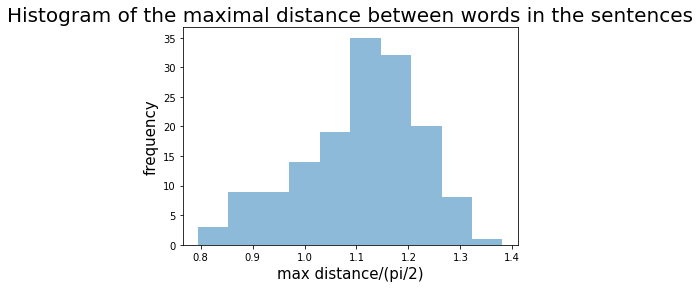

In [8]:
massimi=[]
for i in range(num_sent):
  sentence=sentencesAsVec[i]
  sentence_array = np.array(sentence)
  sentence_array_norms = np.linalg.norm(sentence_array,axis=1)
  np.linalg.norm(sentence_array/sentence_array_norms[:,None],axis=1)
  sentence_array=sentence_array/sentence_array_norms[:,None]
  sdots=sentence_array@sentence_array.transpose()
  sdots=np.clip(sdots,-1.,1.)
  pairwise_euclidean_dist=np.sqrt(2-2*sdots)
  pairwise_geodesic_dist=np.arccos(sdots)
  #media = np.linalg.norm(np.mean(sentence,axis=0))
  #print("media",media)
  massimi.append(np.max(pairwise_geodesic_dist)*2/np.pi)
  #print("max",np.max(pairwise_geodesic_dist)*2/np.pi)
plt.hist(massimi,alpha=0.5)#,ls="solid",lw=3,ec="k",histtype='stepfilled')
plt.title("Histogram of the maximal distance between words in the sentences",fontsize=20)
plt.xlabel("max distance/(pi/2)",fontsize=15)
plt.ylabel("frequency",fontsize=15)



### Refined way: as before but weighting the words for each sentence with Tf-Idf

In [9]:
s2vTFIDF={}
pesi_tot=computeTfIdf(data,corpus)
num_sent=len(data)
count=0
for i in range(num_sent):
  len_sent=len(data[i])
  vettori=[]
  k=0
  for parola in corpus[count:count+len_sent]:
    vett=vocGlove[parola]*pesi_tot[i][k]
    vettori.append(vett) #/np.linalg.norm(vett)
    k += 1
  count += len_sent
  s2vTFIDF[i]= np.mean(vettori,axis=0)


## Other way: weighting each vector with the frequency from Github
https://github.com/rspeer/wordfreq


In [10]:
s2vwordfrq={}

num_sent=len(data)
count=0
for i in range(num_sent):
  len_sent=len(data[i])
  vettori=[]
  k=0
  for parola in corpus[count:count+len_sent]:
    vett=vocGlove[parola]/word_frequency(parola,"en")
    vettori.append(vett) #/np.linalg.norm(vett)
    k += 1
  count += len_sent
  s2vwordfrq[i]= np.mean(vettori,axis=0)


Find the nearest vector to the sentence2vec doing the projection to the vector

In [11]:
def Projection(vector, num):
  '''
  Given the vector and a number num, the function returns the num nearest vectors to vector
  in the sense of cosine distance
  '''
  vicini=[]
  lista=[]
  chiavi=list(word_to_index.keys())

  for word in chiavi:
    pr = np.dot(vector, vocGlove[word])/(np.linalg.norm(vector)*np.linalg.norm(vocGlove[word]))
    lista.append(pr)
  ordine=sorted(lista,reverse=True)
  maxs=[]
  for i in range(num):
    mm=max(lista)
    mm_index=lista.index(mm)
    maxs.append(mm_index)
    lista.remove(mm)
  for i in maxs:
    vicini.append(chiavi[i])
  frase="["
  for i in range(num-1):
    frase += vicini[i].upper()+", "
  frase += vicini[num-1].upper()+"]"

  return frase  

def Projection2(vector,num):
  vicini=[]
  lista=[]
  chiavi=list(word_to_index.keys())

  for word in chiavi:
    pr = np.linalg.norm(vector, vocGlove[word])
    lista.append(pr)
  maxs=[]
  for i in range(num):
    mm=max(lista)
    mm_index=lista.index(mm)
    maxs.append(mm_index)
    lista.remove(mm)
  for i in maxs:
    vicini.append(chiavi[i])
  return vicini  

#Results

In [12]:
Fs=10
Ls=20
print("First row: sentence")
print("3 nearest in meaning words using: \n -1 vanilla mean \n -2 tfidf \n -3 frequency from github")
for i in range(Fs,Ls):
  simili=Projection(sentence2vec[i],3)
  tf=Projection(s2vTFIDF[i],3)
  freq=Projection(s2vwordfrq[i],3)
  print(frasi[i])
  print(simili,",",tf,",",freq)


First row: sentence
3 nearest in meaning words using: 
 -1 vanilla mean 
 -2 tfidf 
 -3 frequency from github
In retrospect, we should have taken to the streets when McConnell refused to let Obama rightfully fill a Supreme Court vacancy. That was an epic fail on our part as citizens.
[QUESTION, BOOMERS, CAN] , [QUESTION, BOOMERS, CAN] , [RIGHTFULLY, RETROSPECT, FUCKING]
Hey, you misguided nincompoops. Here's a glimpse of #FairandBalanced response to a hatemonger https://t.co/inPIz0twO6.
[STUPID, MISGUIDED, LAND] , [MISGUIDED, INNER, LAND] , [HATEMONGER, NINCOMPOOPS, TIME]
Social Security and Medicare are not "Entitlements" that can be renegotiated.   The term is "DEFERRED PAY."  I've paid into the system my entire life, and so have you. Anyone stealing your deferred pay needs to be voted out.
[PAY, WIFE, CHARITABLE] , [PAY, WIFE, PAY] , [RENEGOTIATED, TERM, CHRIS]
'You let a weird guy whisper in your ear and you didn't trust your daughter.' --my 7-year-old girl https://t.co/Iqhx8PUGSo


# k-mean clustering

In [13]:
from sklearn.cluster import KMeans

for i in range(Fs,Ls):
  X = sentencesAsVec[i]
  kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
  centers=np.transpose(kmeans.cluster_centers_)
  print(frasi[i])
  p1=Projection(centers[:,0],1)[:-1]
  p2=Projection(centers[:,1],1)[1:-1]
  p3=Projection(centers[:,2],1)[1:]
  print(p1,p2,p3)


In retrospect, we should have taken to the streets when McConnell refused to let Obama rightfully fill a Supreme Court vacancy. That was an epic fail on our part as citizens.
[REFUSED VACANCY RETROSPECT]
Hey, you misguided nincompoops. Here's a glimpse of #FairandBalanced response to a hatemonger https://t.co/inPIz0twO6.
[RESPONSE HEY NINCOMPOOPS]
Social Security and Medicare are not "Entitlements" that can be renegotiated.   The term is "DEFERRED PAY."  I've paid into the system my entire life, and so have you. Anyone stealing your deferred pay needs to be voted out.
[PAY MAKING DEFERRED]
'You let a weird guy whisper in your ear and you didn't trust your daughter.' --my 7-year-old girl https://t.co/Iqhx8PUGSo
[MOTHER BIT TRUST]
@saladinahmed May the initiative to require neutral redistricting in Michigan succeed.   For those unaware of it: https://t.co/DfBydPOnIH.
[SHOULD MICHIGAN REDISTRICTING]
it's interesting watching this with them because I thought Gollum might scare them but the

# k-mean clustering on the sphere

In [14]:
import os
import sys
import warnings
!pip install geomstats

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")
import logging
import math
from itertools import product
from scipy.stats import beta
import geomstats.algebra_utils as utils
import geomstats.backend as gs
from geomstats.geometry.base import LevelSet
from geomstats.geometry.euclidean import Euclidean, EuclideanMetric
from geomstats.geometry.riemannian_metric import RiemannianMetric
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.geometry.hypersphere import Hypersphere

manifold = Hypersphere(dim=49)
metric = manifold.metric


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 8.4 MB/s 
     |████████████████████████████████| 11.2 MB 34.1 MB/s 
     |████████████████████████████████| 957 kB 28.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


INFO:root:Using numpy backend


In [15]:
def ProjectionG(vector):
  vicini=[]
  lista=[]
  chiavi=list(word_to_index.keys())
  n=np.linalg.norm(vector)
  vector=vector/np.sqrt(n**2+1.e-6)

  for word in chiavi:
    v2=vocGlove[word]/np.linalg.norm(vocGlove[word])
    pr = np.math.acos( np.dot(vector, v2))
    lista.append(pr)
  mm=min(lista)
  mm_index=lista.index(mm)
  vicino=chiavi[mm_index]
  return vicino.upper()

In [16]:
print("k-mean clustering geodesic")
for i in range(10,20):#Fs,Ls):
  data = np.array(sentencesAsVec[i])
  kmeans = RiemannianKMeans(metric, 3, tol=1e-3, init_step_size=1.0)
  kmeans.fit(data)
  labels = kmeans.predict(data)
  centroids = np.transpose(kmeans.centroids)
  print(frasi[i])
  c1=centroids[:,0]/np.linalg.norm(centroids[:,0])
  c2=centroids[:,1]/np.linalg.norm(centroids[:,1])
  c3=centroids[:,2]/np.linalg.norm(centroids[:,2])
  print("[",ProjectionG(c1),ProjectionG(c2),ProjectionG(c3),"]")

k-mean clustering geodesic


In retrospect, we should have taken to the streets when McConnell refused to let Obama rightfully fill a Supreme Court vacancy. That was an epic fail on our part as citizens.
[ HONESTLY OBAMA COURT ]


Hey, you misguided nincompoops. Here's a glimpse of #FairandBalanced response to a hatemonger https://t.co/inPIz0twO6.
[ FUN RESPONSE HERES ]


Social Security and Medicare are not "Entitlements" that can be renegotiated.   The term is "DEFERRED PAY."  I've paid into the system my entire life, and so have you. Anyone stealing your deferred pay needs to be voted out.
[ STEALING NEEDS PAY ]


'You let a weird guy whisper in your ear and you didn't trust your daughter.' --my 7-year-old girl https://t.co/Iqhx8PUGSo
[ CRAZY EAR TRUST ]


@saladinahmed May the initiative to require neutral redistricting in Michigan succeed.   For those unaware of it: https://t.co/DfBydPOnIH.
[ SHOULD REDISTRICTING CONVINCED ]
it's interesting watching this with them because I thought Gollum might scare them but they mostly just get upset when he's mistreated.


[ MISTREATED GOLLUM REALLY ]


I have but one request this Christmas, guys. Take the #WarOnChristmas hashtag and fill it with accounts of the horrors of battling elves across snowy fields and firing anti-aircraft missiles at sleds streaking overhead.
[ COME OVERHEAD FIELDS ]


It is fascinating to see female Democratic senators (with the help of male colleagues) take this coordinated action against Al Franken.
[ ACTION YOUNG DEMOCRATIC ]


marvel should make a mockumentary about loki as odin and the behind the scenes drama that went on while loki was trying to produce and direct his play. i wanna see tantrums about sets, actors and interviews with asgardians who are ya we know it's loki
[ ODIN WELL LOKI ]


It seems like a whole bunch of narcissistic sexually harassing dudes who have never had to notice all the people around them who cleaned up their messes are suddenly being handed mops.  I'm all for mailing a few mops to the White House, personally.
[ TAKEN MESSES SEXUALLY ]
